# SR model (basic)
- Using basic SR to predict participants' choice in a probabilistic sequential prediction task (i.e., Ren, Zhang and Luo, 2022)

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor
import pytensor.tensor as pt
import scipy

from scipy import stats
from scipy.io import loadmat

%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=FutureWarning)
RANDOM_SEED = 286
rng = np.random.default_rng(RANDOM_SEED)

## Read data

In [2]:
data_behv   = '/Users/renxiangjuan/Nextcloud/' 
path_or_buf  = data_behv +'choiceData_pd.csv'
choiceData_pd = pd.read_csv(filepath_or_buffer=path_or_buf)
choiceData_pd = choiceData_pd.drop(columns=["Unnamed: 0"])
choiceData_pd

,subNo,trialNo,cueObj,respObj0,respObj1,respObj2,respObj3,objNum,choice0,choice1,choice2,choice3,choiceIdx
0,1,1,0,2,13,0,0,2,1,0,-1,-1,0
1,1,2,2,4,11,8,0,3,0,1,0,-1,1
2,1,3,4,5,6,10,9,4,0,0,0,1,3
3,1,4,5,4,12,0,0,2,0,1,-1,-1,1
4,1,5,4,5,14,9,13,4,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494,1,1496,10,12,1,5,0,3,0,0,1,-1,2
1495,1,1497,12,11,5,0,0,2,1,0,-1,-1,0
1496,1,1498,11,13,0,0,0,2,1,0,-1,-1,0
1497,1,1499,13,14,5,1,0,3,1,0,0,-1,0


## updating successor matrix and calculating logp

In [3]:
def updateM_llik_cal(stim, respTgt, resp, optCol, choiceItm, Ms, I, alpha, gamma, beta): 
    Ms = pt.set_subtensor(Ms[stim, :], Ms[stim, :] + alpha * (I[respTgt, :] + gamma * Ms[respTgt, :] - Ms[stim, :])) 
    Qs = Ms[stim, resp[0 : optCol]]
    Qs_exp = Qs * beta
    logp_actions = Qs_exp - pt.logsumexp(Qs_exp) # , axis=1, keepdims=True
    logp_actions = logp_actions[choiceItm] 
    return Ms, logp_actions

## likelihood calculation

In [4]:
def pytensor_llikSR(stim, respTgt, resp, optCol, choiceItm, Ms, I, alpha, gamma, beta):
    result, updates = pytensor.scan(fn=updateM_llik_cal,
                                    outputs_info=[Ms, None], 
                                    sequences=[stim, respTgt, resp, optCol, choiceItm],
                                    non_sequences=[I, alpha, gamma, beta])
    return pt.sum(result[1])

In [5]:
# stim: fromNode; 
# resp: targetNode + distractor; 
# dtrChoiceID: choice; 
# optCol: number of target + distractor;
# choiceItm: choice index;
stim     = choiceData_pd.loc[:, 'cueObj']
trialLen = stim.shape[0] 
stim     = stim.to_numpy(dtype=np.int32) 
resp     = choiceData_pd.loc[:, ['respObj0', 'respObj1', 'respObj2', 'respObj3']]
resp     = pd.DataFrame.to_numpy(resp, dtype=np.int32)
respTgt  = choiceData_pd.loc[:, 'respObj0'] 
respTgt  = respTgt.to_numpy(dtype=np.int32) 
dtrChoiceID = choiceData_pd.loc[:, ['choice0', 'choice1' , 'choice2', 'choice3']]
dtrChoiceID = pd.DataFrame.to_numpy(dtrChoiceID, dtype=np.int32)
optCol      = choiceData_pd.loc[:, 'objNum']
optCol      = optCol.to_numpy(dtype=np.int32)
choiceItm   = choiceData_pd.loc[:, 'choiceIdx']
choiceItm   = choiceItm.to_numpy(dtype=np.int32) 
Ms          = np.eye(15, dtype=np.float32)
I           = np.eye(15, dtype=np.int32)

# turn array into tensor variables
stim        = pt.as_tensor_variable(stim, dtype="int32")
resp        = pt.as_tensor_variable(resp, dtype="int32")
respTgt     = pt.as_tensor_variable(respTgt, dtype="int32")
dtrChoiceID = pt.as_tensor_variable(dtrChoiceID, dtype="int32")
optCol      = pt.as_tensor_variable(optCol, dtype="int32")
choiceItm   = pt.as_tensor_variable(choiceItm, dtype="int32")
Ms = pt.as_tensor_variable(Ms, dtype="float64")
I  = pt.as_tensor_variable(I, dtype="int32")

## model fitting

In [6]:
with pm.Model() as SRmodel_basic:
    # gamma (discounting factor) prior
    gamma = pm.Beta("gamma", alpha=1, beta=1)
    # alpha (learning rate) prior
    alpha = pm.Beta("alpha", alpha=1, beta=1)
    # beta (inverse temperature) prior
    beta  = pm.HalfNormal(name="beta", sigma=10) #beta  = pm.Gamma("beta", alpha=0.001, beta=0.001)
    
    like = pm.Potential(name="like", var=pytensor_llikSR(stim, respTgt, resp, optCol, choiceItm, Ms, I, alpha, gamma, beta))

In [7]:
with SRmodel_basic:
    idata = pm.sample(target_accept = 0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gamma, alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3294 seconds.


array([[<AxesSubplot: title={'center': 'gamma'}>,
        <AxesSubplot: title={'center': 'gamma'}>],
       [<AxesSubplot: title={'center': 'alpha'}>,
        <AxesSubplot: title={'center': 'alpha'}>],
       [<AxesSubplot: title={'center': 'beta'}>,
        <AxesSubplot: title={'center': 'beta'}>]], dtype=object)

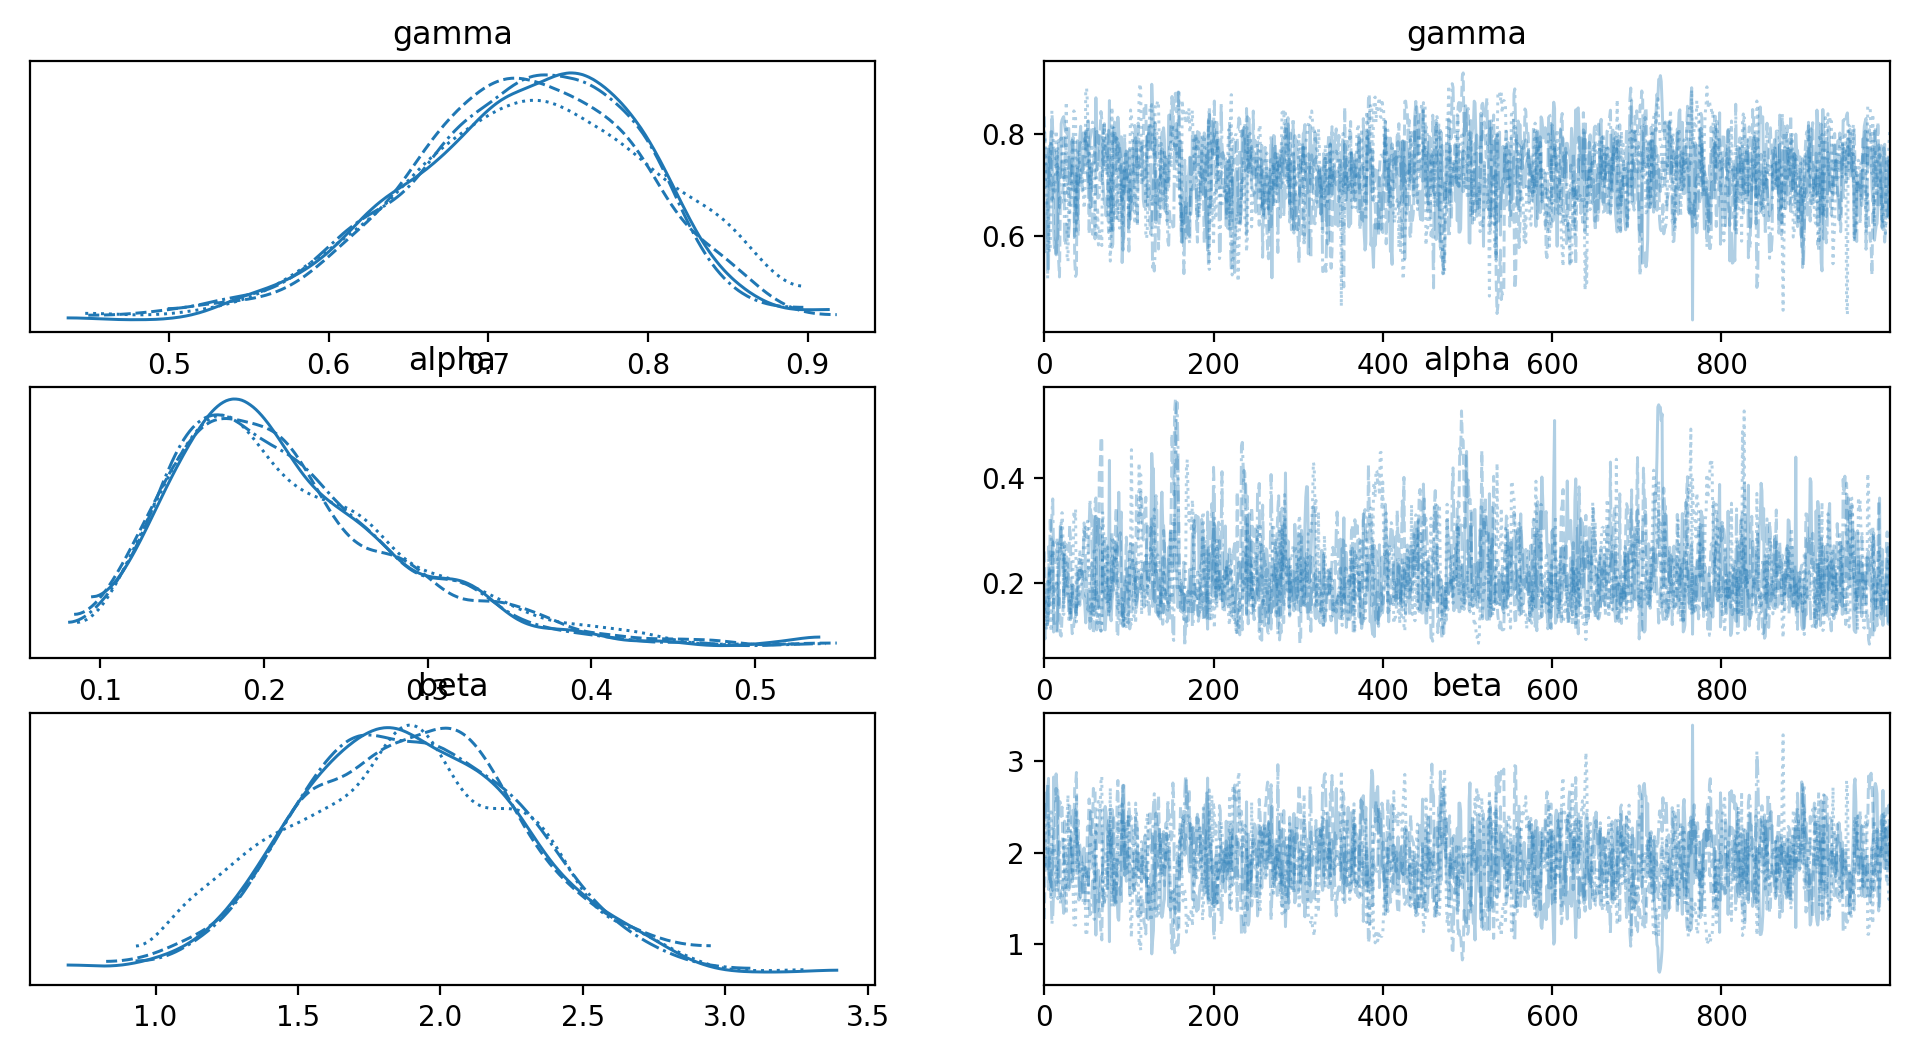

In [8]:
az.plot_trace(idata)